In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as pl
import visualize as vis
import danframe as dan
import kontin as con
import lines as lin
import numpy as np
import astropy.io.fits as fts
import binner as bn

pl.rcParams["figure.figsize"] = (10,6) # Bigger figures

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data series and line definitions
This loads the entire sS1 run ("alla ska med"), there is so far no restriction on the data quality. The continum is fitted using points selected automatically with the "top 5%" and "segment" algorithms. 

The line windows have been made semi-automatically, but they should probably be revisited as I think they where created without using the linear continum correction the dataframes get.

In [2]:
s6405_t5p = dan.frameseries("data/6405_aS1","top 5%")
s6405_seg = dan.frameseries("data/6405_aS1","segments")

# Load continuum contrast 
cont, =  fts.open("data/6405_aS1__concont.fits")
#From plot decide to keep top 10 scoring frames
# A= cont.data; A.sort(); pl.plot(A,'o'); pl.show() 

# Group cont with order value, sort by cont in decreasing order, then save only the top ten frames
qual = [(x,i) for i,x in enumerate(cont.data)] ; qual.sort(key=lambda x: x[0],reverse=True)
s6405_t5p.frames = [s6405_t5p.frames[x[1]] for x in qual[:12]]

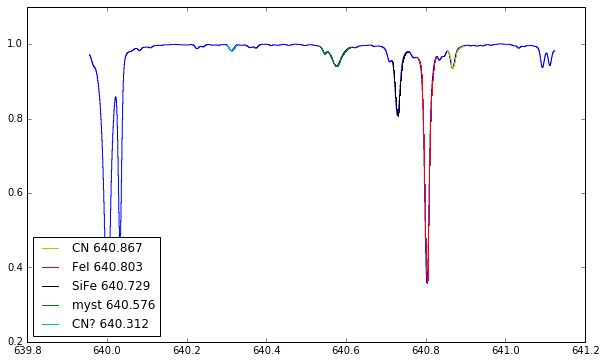

In [3]:
lins = lin.make_lines_from_wins(s6405_t5p,s6405_t5p.pkwindows)
CN   = lins[0]
FeI  = lins[1]
SiFe = lins[2]
myst = lins[3]
CNq  = lins[4]

s6405_t5p.normalize()
s6405_seg.normalize()


pl.step(s6405_t5p.lmbd,s6405_t5p.ref)
pl.step(s6405_t5p.lmbd[CN.idx],s6405_t5p.ref[CN.idx],'y',label="CN "+CN.name)
pl.step(s6405_t5p.lmbd[FeI.idx],s6405_t5p.ref[FeI.idx],'r',label="FeI "+FeI.name)
pl.step(s6405_t5p.lmbd[SiFe.idx],s6405_t5p.ref[SiFe.idx],'k',label="SiFe "+SiFe.name)
pl.step(s6405_t5p.lmbd[myst.idx],s6405_t5p.ref[myst.idx],'g',label="myst "+myst.name)
pl.step(s6405_t5p.lmbd[CNq.idx],s6405_t5p.ref[CNq.idx],'c',label="CN? "+CNq.name)
pl.legend(loc="lower left")
pl.show()

### The unknown line in closer detail

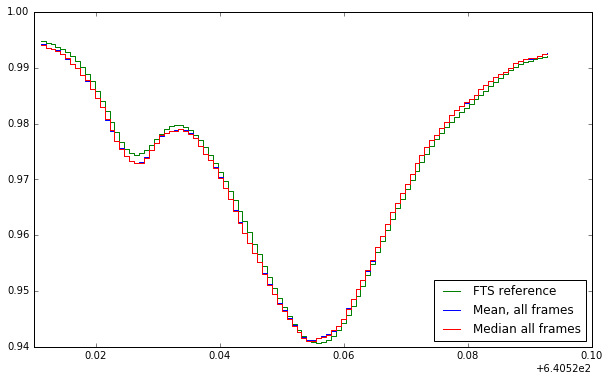

In [81]:
DATA = s6405_t5p.frames[0].data[:,myst.idx]
for frm in s6405_t5p.frames[1:]:
    DATA = np.concatenate((DATA,frm.data[:,myst.idx]),axis=0)

mn  = DATA.mean(axis=0)
mdn = np.median(DATA,axis=0)
pl.step(s6405_t5p.lmbd[myst.idx],s6405_t5p.ref[myst.idx],'g',label="FTS reference")
pl.step(s6405_t5p.lmbd[myst.idx],mn,'b',label="Mean, all frames" )
pl.step(s6405_t5p.lmbd[myst.idx],mdn,'r',label="Median all frames")
pl.legend(loc="lower right")
pl.show()

## Measure line center and bottom
The function uses the min value of the reference spectra inside the line window, and then takes some additional\*  points to either side of this and fits a second order polynomial to them:

$$ p(\lambda) = a\lambda^ 2 + b\lambda + c $$
where the fits gives $a,b,c$. 

The line central value is then given as 
$$ \lambda_{cen} = \frac{-b}{2a} $$
and the line bottom is then simply $p(\lambda_{cent})$.

To estimate the goodness-of-fit, I calculate  the root mean square error in a window one point larger (to either side) than the window used for fitting. Additionally, I calculate the square deviation from the line centre of the reference spectra and add twice this to the mean squared error of the fit to punish fits that for one reason or other predict a central value far outside of the line window. This usually happens when the points being fitted only include the side of a line, and so the central value and line bottom are completely spurious. The total error is then
$$
\textrm{Err} = \sqrt{ \mu\left[ (\textrm{data} - p(\lambda_{test})^2\right] +2 \times (\lambda_{cen}-\lambda_{ref})^2 }
$$

Points above the 89% level of this statistic are then excluded from the plots.

## Equivalent width
The equivalent width of a spectral line in a discreetly sampled spectrum is given by
$$
\textrm{EW} = \Delta \lambda \sum_i \frac{I_C - I_i}{I_C}
$$
where $\Delta \lambda$ a constant wavelenght bin, $I_C$ the continuum level, and $I_i$ the intensity in bin $i$. Since the spectra are expressed in intensity relative the continiuum we have $I_C = 1$.Further, the wavelenght bins given by the calibration are not uniform so the EW becomes
$$
\textrm{EW} =  \sum_i \Delta \lambda_i \left(1 - I_i\right)
$$
This has been calculated and is presented as the equivalent width below.
\* To be described later

In [12]:
#Helpful constants
vel = 0; bot = 1; cont = 2; err = 3; ew  = 4; mn  = 5; var = 6; ske = 7; kur = 8
mesFeI   = FeI.measure(s6405_t5p)
mesSiFe  = SiFe.measure(s6405_t5p)
mesmyst  = myst.measure(s6405_t5p)
mesCN    = CN.measure(s6405_t5p)
mesCNq   = CNq.measure(s6405_t5p)

### FeI line

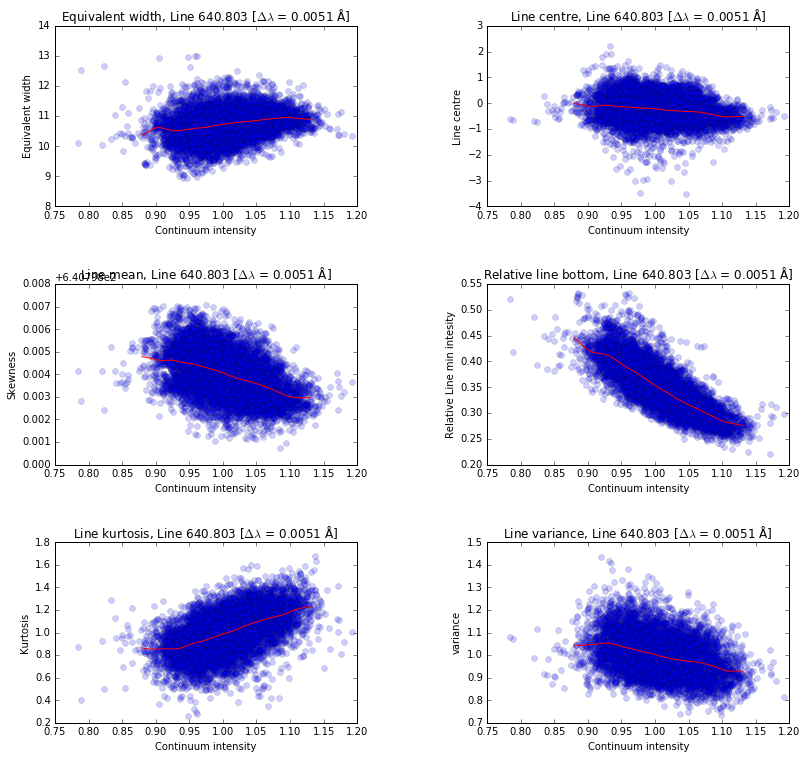

In [5]:
pl.rcParams["figure.figsize"] = (12,11)
vis.plot_linemap(mesFeI,FeI)

### The Unknown line

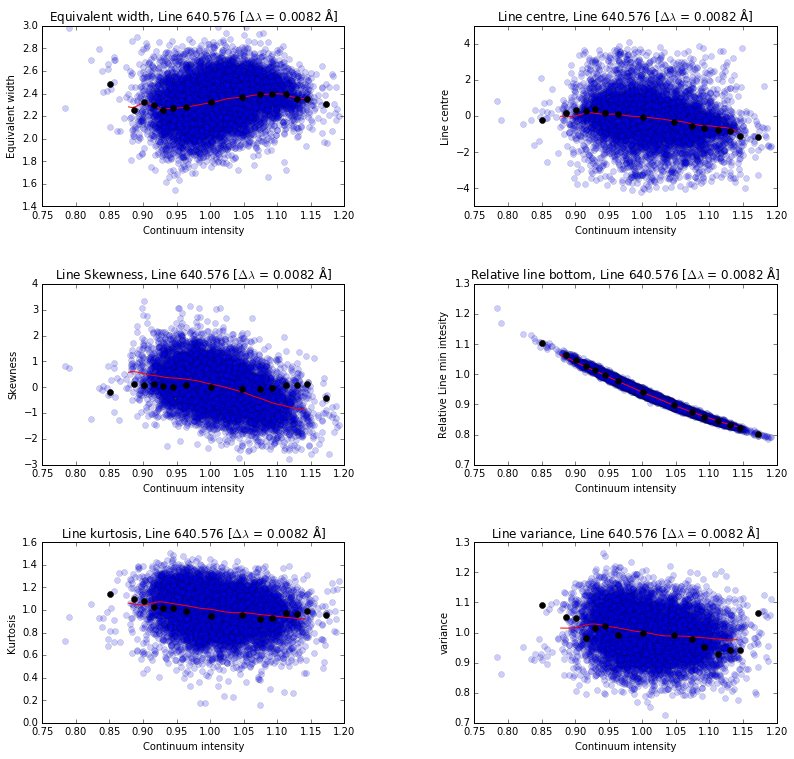

In [26]:
quant = mesmyst[cont].reshape(-1)
#binned = bn.binned_framegroup(myst,s6405_t5p,quant,mesmyst[err] < np.percentile(mesmyst[err],89))
mesBinnMyst = binned.measure()

#pl.plot(binned.cont.reshape(-1),mesBinnMyst[ew],'ko')
#pl.show()
pl.rcParams["figure.figsize"] = (12,11)
vis.plot_linemap(mesmyst,myst,binned=(mesBinnMyst,binned.cont.reshape(-1)))

### Si + Fe line

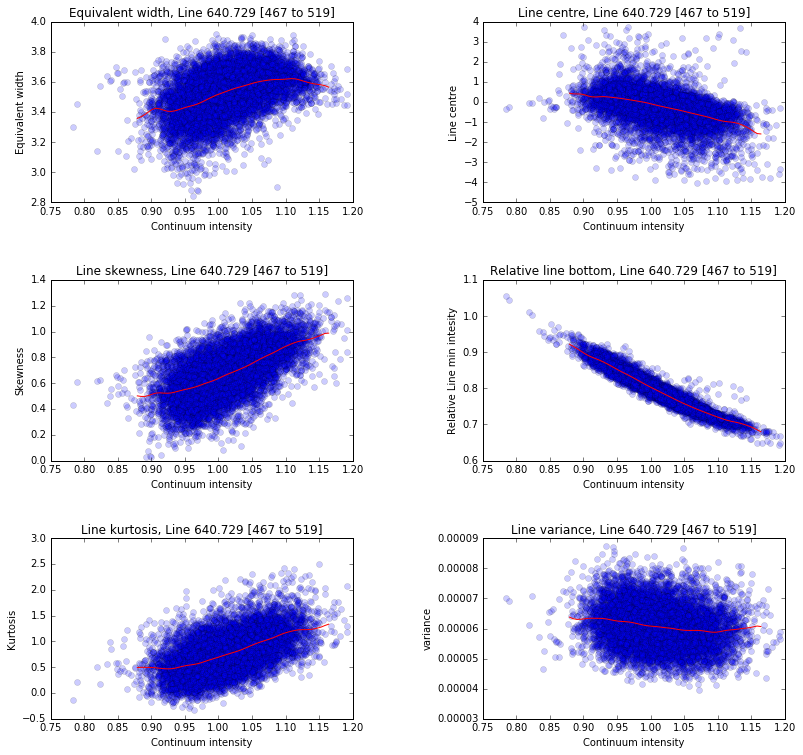

In [85]:
vis.plot_linemap(mesSiFe,SiFe)

### CN line 

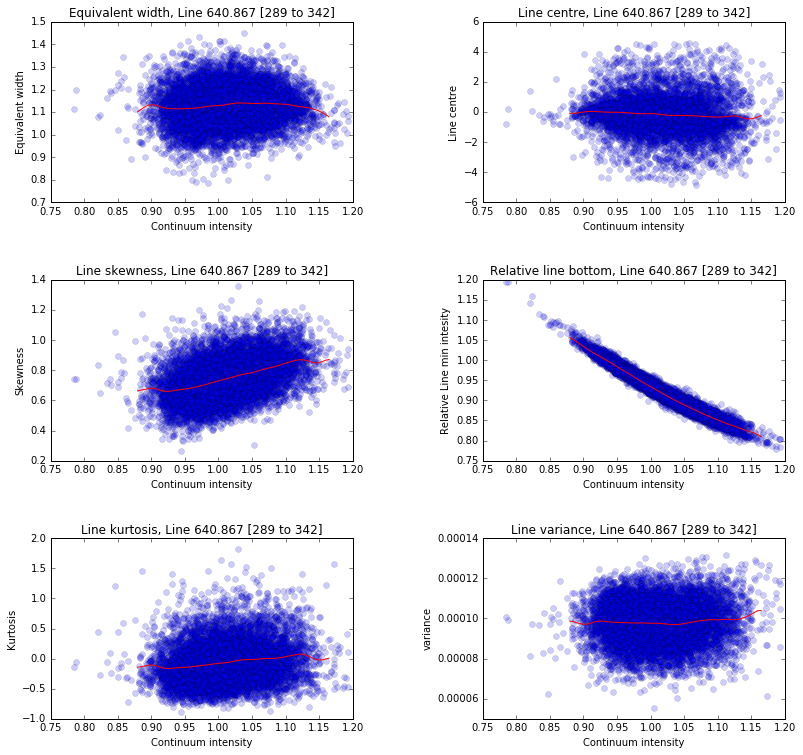

In [86]:
vis.plot_linemap(mesCN,CN)

### CN? line

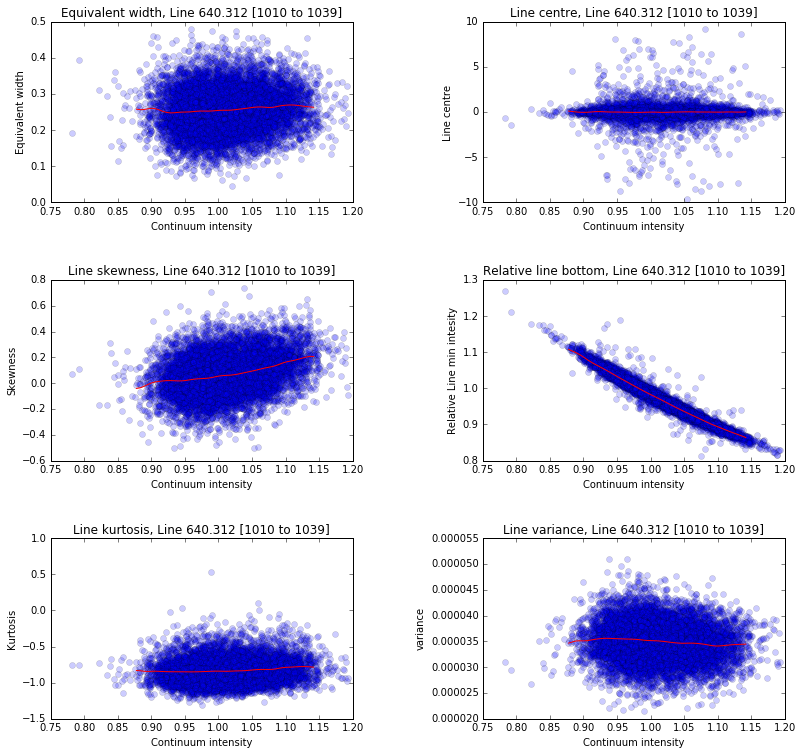

In [87]:
vis.plot_linemap(mesCNq,CNq)

/opt/miniconda/envs/master/lib/python3.5/site-packages/astropy/stats/bayesian_blocks.py:421: UserWarning: p0 does not seem to accurately represent the false positive rate for event data. It is highly recommended that you run random trials on signal-free noise to calibrate ncp_prior to achieve a desired false positive rate.
  warnings.warn('p0 does not seem to accurately represent the false '


/opt/miniconda/envs/master/lib/python3.5/site-packages/ipykernel/__main__.py:17: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 9576 but corresponding boolean dimension is 16758


19


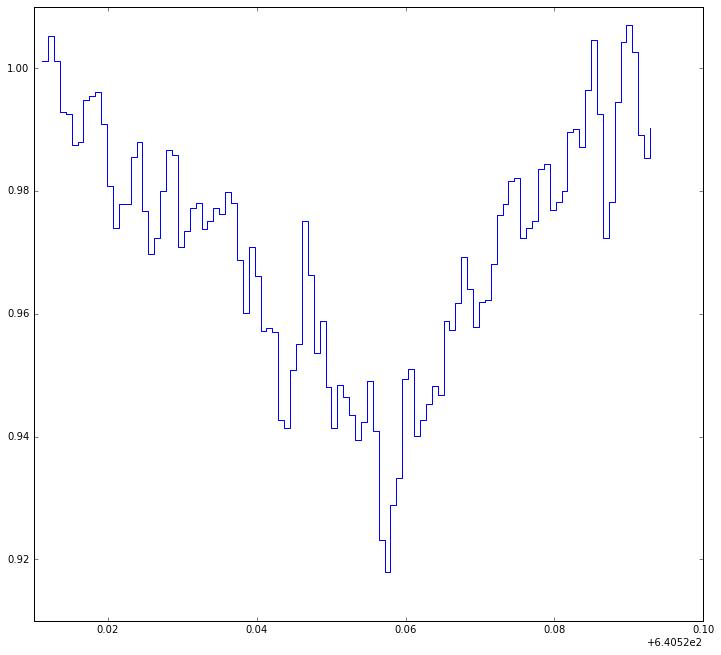

IndexError: index 11045 is out of bounds for axis 0 with size 9576

In [88]:
bins = [0.78350252, 0.83925517, 0.85952886, 0.87980255, 0.8899394 , 0.91528151,
         0.93048678, 0.9416458 , 0.9548244 , 0.96800301, 0.98118161, 0.99436022,
         1.00753883, 1.02071743, 1.03389604, 1.04707465, 1.06025325, 1.07343186,
         1.08661047, 1.09978907, 1.11296768, 1.12614628, 1.13932489, 1.1525035 ,
         1.1656821 , 1.17886071, 1.19203932] # Hand chosen to keep the lower tail a bit better fed
bins = [0.78350252, 0.85952886, 0.8899394 , 0.91528151,
         0.93048678, 0.9416458 , 0.9548244 , 0.96800301, 0.98118161, 0.99436022,
         1.00753883, 1.02071743, 1.03389604, 1.04707465, 1.06025325, 1.07343186,
         1.08661047, 1.09978907, 1.11296768, 1.12614628, 1.13932489, 1.1525035 ,
         1.1656821 , 1.17886071, 1.19203932]

counts, bins = np.histogram(Myst_t5_EWco,bins)
sorting = np.digitize(Myst_t5_EWco,bins,right=True)
binned = []
for i in np.unique(sorting)[:-1]:
#    binned.append( DATA[sorting == i,:].mean(axis=0) )
    binned.append( np.median(DATA[sorting == i,:],axis=0) )
    print(counts[i])
    pl.step(s6405_t5p.lmbd[myst.idx],binned[-1]);
    pl.show()

#pl.hist(Myst_t5_EWco,31)

